In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


CONFIG = {
    "device": "cuda:0" if torch.cuda.is_available() else "cpu",
    "batch_size": 512,
    "num_epochs": 500,
    "learning_rate": 0.1,
    "weight_decay": 1e-2,
    "model_save_path": "best_resnet_model2.pth"
}

print(f"Using device: {CONFIG['device']}")


Using device: cuda:0


In [2]:
batch_size = 256

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),     
    transforms.RandomHorizontalFlip(),       
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = datasets.CIFAR10(root='./dataset', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./dataset', train=False, download=True, transform=test_transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

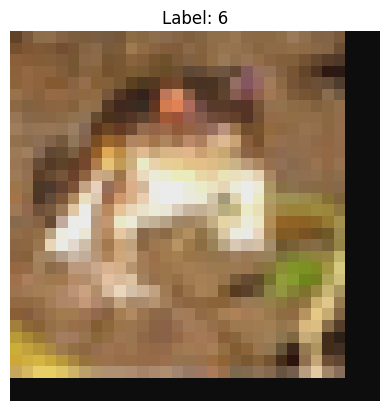

In [3]:

image, label = train_dataset[0]
image = image * 0.5 + 0.5 
npimg = image.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))  
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()



In [4]:
print(train_dataset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./dataset
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [5]:
print(train_dataset[0])

(tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ...,  0.3490,  0.3882,  0.3176],
         [-1.0000, -1.0000, -1.0000,  ...,  0.0588,  0.0667,  0.0745],
         ...,
         [-1.0000, -1.0000, -1.0000,  ...,  0.2000,  0.0353, -0.0824],
         [-1.0000, -1.0000, -1.0000,  ...,  0.0980, -0.2941, -0.6471],
         [-1.0000, -1.0000, -1.0000,  ..., -0.1843, -0.5765, -0.7882]],

        [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ...,  0.1059,  0.1608,  0.0902],
         [-1.0000, -1.0000, -1.0000,  ..., -0.2627, -0.2471, -0.2078],
         ...,
         [-1.0000, -1.0000, -1.0000,  ..., -0.0588, -0.1608, -0.2863],
         [-1.0000, -1.0000, -1.0000,  ..., -0.1451, -0.4431, -0.8353],
         [-1.0000, -1.0000, -1.0000,  ..., -0.4510, -0.7804, -1.0000]],

        [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -

In [6]:
img, label = train_dataset[0]
img.shape


torch.Size([3, 32, 32])

In [7]:
label

6

In [8]:
train_dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [9]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 1: 32x32 -> 16x16
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(64) # ADDED
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(64) # ADDED

        # Block 2: 16x16 -> 8x8
        self.conv3_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(128) # ADDED
        self.conv3_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(128) # ADDED

        # Block 3: 8x8 -> 4x4
        self.conv5_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn5_1 = nn.BatchNorm2d(256) # ADDED
        self.conv5_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn5_2 = nn.BatchNorm2d(256) # ADDED
        self.conv5_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn5_3 = nn.BatchNorm2d(256) # ADDED

        # Block 4: 4x4 -> 2x2
        self.conv7_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn7_1 = nn.BatchNorm2d(512) # ADDED
        self.conv7_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn7_2 = nn.BatchNorm2d(512) # ADDED
        self.conv7_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn7_3 = nn.BatchNorm2d(512) # ADDED


        self.fc1 = nn.Linear(512 * 2 * 2, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 256)
        self.fc4 = nn.Linear(256, 10)

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # The ideal order is Conv -> BatchNorm -> ReLU
        x = self.relu(self.bn1_1(self.conv1_1(x)))
        x = self.relu(self.bn1_2(self.conv1_2(x)))
        x = self.pool(x)

        x = self.relu(self.bn3_1(self.conv3_1(x)))
        x = self.relu(self.bn3_2(self.conv3_2(x)))
        x = self.pool(x)

        x = self.relu(self.bn5_1(self.conv5_1(x)))
        x = self.relu(self.bn5_2(self.conv5_2(x)))
        x = self.relu(self.bn5_3(self.conv5_3(x)))
        x = self.pool(x)

        x = self.relu(self.bn7_1(self.conv7_1(x)))
        x = self.relu(self.bn7_2(self.conv7_2(x)))
        x = self.relu(self.bn7_3(self.conv7_3(x)))
        x = self.pool(x)

        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)

        return x


In [10]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, s=1):
        super(ResBlock, self).__init__()
            
        self.conv1 = nn.Conv2d(in_channels,out_channels, 3,stride = s, padding = 1, bias = False)
        self.conv2 = nn.Conv2d(out_channels, out_channels,3,  padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.shortcut = nn.Sequential()
        if s != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=s, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = out + self.shortcut(x) 
        out = self.relu(out)
        return out
        

class ResNet(nn.Module):
    def __init__(self, n, res_block):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3 ,16 ,3 ,padding = 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace = True)
        self.layers = nn.ModuleList()
        self.out_channels = 16
        for i in range(n):
            self.layers.append(ResBlock(16,16))
        self.layers.append(ResBlock(16,32,2))
        for i in range(n-1):
            self.layers.append(ResBlock(32,32))
        self.layers.append(ResBlock(32,64,2))
        for i in range(n-1):
            self.layers.append(ResBlock(64,64))
        
        
        self.res_network = nn.Sequential(*self.layers)
        self.adaPool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.res_network(x)
        x = self.adaPool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        

        return x


In [11]:
class EnsembleModel(nn.Module):
    def __init__(self, models):
        super(EnsembleModel, self).__init__()
        self.models = models
        
        for model in self.models:
            model.eval() 
            for param in model.parameters():
                param.requires_grad = False

    def forward(self, x):
        all_probs = []
        for model in self.models:
            logits = model(x)
            probs = F.softmax(logits, dim=1)
            all_probs.append(probs)
        
        average_probs = torch.mean(torch.stack(all_probs), dim=0)
        return torch.log(average_probs)

In [12]:
def train_model(model, num_epochs, criterion, optimizer, scheduler, device, save_path):
    model.to(device)
    best_val_loss = float('inf') 
    
    for epoch in range(num_epochs):
        print(f"--- Epoch {epoch+1}/{num_epochs} ---")
        
        model.train()
        train_losses = []
        
        loop = tqdm(train_loader, desc="Training") 
        for batch_idx, (data, targets) in enumerate(loop):
            data = data.to(device)
            targets = targets.to(device)

            scores = model(data)
            loss = criterion(scores, targets)
            train_losses.append(loss.item())
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if scheduler:
                scheduler.step()
        
            loop.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])

        model.eval()
        val_losses = []
        with torch.no_grad():
            for data, targets in tqdm(test_loader, desc="Validating"): 
                data, targets = data.to(device), targets.to(device)
                scores = model(data)
                loss = criterion(scores, targets)
                val_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)
        avg_val_loss = np.mean(val_losses)
    
        print(f"Avg Train Loss: {avg_train_loss:.4f} | Avg Val Loss: {avg_val_loss:.4f}")
    
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_path)
            print(f"New best model saved to {save_path}")

def check_accuracy(data_loader, model, device):
    print(f"Checking accuracy on {'train' if data_loader.dataset.train else 'test'} dataset...")
    num_correct = 0 
    num_samples = 0 
    model.to(device)
    model.eval()

    with torch.no_grad():
        for data, targets in data_loader:
            data = data.to(device)
            targets = targets.to(device)
            
            scores = model(data)
            _, predicted = scores.max(1)
            num_correct += (predicted == targets).sum()
            num_samples += targets.size(0)
            
        acc = float(num_correct) / float(num_samples) * 100
        print(f"Accuracy: {num_correct}/{num_samples} ({acc:.2f}%)")

    model.train() 

In [13]:
if __name__ == "__main__":
    device =  "cuda:0" if torch.cuda.is_available() else "cpu"
    model = ResNet(9, ResBlock)
    
    
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    optimizer = optim.SGD(
        model.parameters(), 
        lr=CONFIG['learning_rate'], 
        momentum=0.9,
        weight_decay=CONFIG['weight_decay']
    )
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=0.01, 
        steps_per_epoch=len(train_loader), 
        epochs=CONFIG['num_epochs']
    )

    train_model(
        model=model, 
        num_epochs=CONFIG['num_epochs'], 
        criterion=criterion, 
        optimizer=optimizer, 
        scheduler=scheduler,
        device=CONFIG['device'],
        save_path=CONFIG['model_save_path']
    )

    print("\n--- Final Performance of Best Model ---")
    model.load_state_dict(torch.load(CONFIG['model_save_path']))
    check_accuracy(train_loader, model, CONFIG['device'])
    check_accuracy(test_loader, model, CONFIG['device'])

--- Epoch 1/500 ---


Training:  31%|████████████████████████████████████▋                                                                                   | 60/196 [00:08<00:18,  7.19it/s, loss=2.21, lr=0.0004]


KeyboardInterrupt: 

In [15]:
module7 = ResNet(9, ResBlock)
module8 = ResNet(5, ResBlock)
module9 = ResNet(9, ResBlock)
module10 = ResNet(9, ResBlock)


module7.load_state_dict(torch.load('best_resnet_model4.pth'))
module8.load_state_dict(torch.load('best_resnet_model5.pth'))
module9.load_state_dict(torch.load('best_resnet_model1.pth'))
module9.load_state_dict(torch.load('best_resnet_model2.pth'))




modules = nn.ModuleList()

modules.append(module7)
modules.append(module8)
modules.append(module9)
modules.append(module10)



ensemble = EnsembleModel(modules)

In [16]:
check_accuracy(train_loader, ensemble, device)
check_accuracy(test_loader, ensemble, device)

Checking accuracy on train dataset...
Accuracy: 49967/50000 (99.93%)
Checking accuracy on test dataset...
Accuracy: 9469/10000 (94.69%)


In [18]:
check_accuracy(train_loader, module9, device)
check_accuracy(test_loader, module9, device)

Checking accuracy on train dataset...
Accuracy: 49967/50000 (99.93%)
Checking accuracy on test dataset...
Accuracy: 9417/10000 (94.17%)
